# Non-Unitary Operators for the Non-Hermitian Skin Effect

Paper to be replicated: https://arxiv.org/pdf/2311.10143

Addition Resources Consulted:
- https://link.aps.org/pdf/10.1103/PRXQuantum.2.010342
- https://medium.com/mdr-inc/time-evolution-operators-be2968493b86 (note there are some notable errors)
- 

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [1]:
%pip install -r requirements.txt


  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached anyio-4.10.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached argon2_cffi-25.1.0-py3-none-any.whl.metadata (4.1 kB)
  Using cached argon2_cffi_bindings-25.1.0-cp39-abi3-macosx_11_0_arm64.whl.metadata (7.4 kB)
  Using cached arrow-1.3.0-py3-none-any.whl.metadata (7.5 kB)
  Using cached async_lru-2.0.5-py3-none-any.whl.metadata (4.5 kB)
  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
  Using cached babel-2.17.0-py3-none-any.whl.metadata (2.0 kB)
  Using cached beautifulsoup4-4.13.4-py3-none-any.whl.metadata (3.8 kB)
  Using cached bleach-6.2.0-py3-none-any.whl.metadata (30 kB)
  Using cached certifi-2025.8.3-py3-none-any.whl.metadata (2.4 kB)
  Using cached cffi-1.17.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (1.5 kB)
  Using cached charset_normalizer-3.4.3-cp313-cp313-macosx_10_13_universal2.whl.metadata (36 kB)
  Using cached contourpy-1.3.3-cp313-cp313-macosx_11_0_arm64.whl.metadata 

In [2]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Statevector, Operator
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
# from qiskit.primitives import Sampler
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Statevector

# from tqdm.notebook import tqdm

from numpy import sin, cos
import numpy as np
from scipy.linalg import expm, sqrtm

from scipy.optimize import differential_evolution, dual_annealing, minimize

from itertools import product

import random

import json





In [3]:
# service = QiskitRuntimeService()
BACKEND = AerSimulator()
pass_manager = generate_preset_pass_manager(backend=BACKEND, optimization_level=0)
estimator = Estimator(mode=BACKEND)
sampler = Sampler(mode=BACKEND)

## I. Hatano-Nelson Model

Note $\hat{X}^+ = \frac{\hat{X} + i \hat{Y}}{2}$ and $\hat{X}^- = \frac{\hat{X} - i \hat{Y}}{2}$

In [4]:
X_gate = np.array([[0, 1], 
                   [1, 0]])

Y_gate = np.array([[0, -1j],
                   [1j, 0]])

I_gate = np.array([[1, 0], 
                   [0, 1]])

X_plus = 0.5 * (X_gate + 1j * Y_gate)
X_minus = 0.5 * (X_gate - 1j * Y_gate)

In [5]:
# Helper function, generates U_j_nonH
def get_U_j_nonH(J, gamma, index, N, timestep):
    product_1 = np.kron(X_plus, X_minus)
    product_2 = np.kron(X_minus, X_plus)
    exponent = 1j * timestep * ( (J - gamma) * product_1 + (J + gamma) * product_2)
    
    if index == 0:
        U_j_nonH = np.kron(np.eye(2 ** (N-2)), expm(exponent))
    if index == N - 2:
        U_j_nonH = np.kron(expm(exponent), np.eye(2 ** (N-2)))
    else: 
        U_j_nonH = np.kron(np.kron(np.eye(2 ** (N - 2 - index)), expm(exponent)), np.eye(2 ** (index)))
    return U_j_nonH
    


# Helper function, generates R_HN
def get_R_HN(J, gamma, N, timestep):
    res_even = np.eye(2 ** N)
    res_odd = np.eye(2 ** N)
    for i in range(N - 1):
        if i % 2 == 0:
            res_even = np.matmul(res_even, get_U_j_nonH(J, gamma, i, N, timestep))
        else:
            res_odd = np.matmul(res_odd, get_U_j_nonH(J, gamma, i, N, timestep))
    return np.matmul(res_even, res_odd)

# Generates U_HN 
def get_U_HN(J, gamma, N, timestep):
    R_HN = get_R_HN(J, gamma, N, timestep)

    A, sig, Bh = np.linalg.svd(R_HN)
    eigval, _ = np.linalg.eig(np.matmul(R_HN.conj().T, R_HN))
    u_square_inverse = max(eigval)
    u_square = 1/u_square_inverse 
    C = np.matmul(np.matmul(A, sqrtm(np.eye(2 ** N) - u_square * np.diag(np.square(sig)))), Bh)

    u_R_HN = np.sqrt(u_square) * R_HN
    W = np.concatenate((np.concatenate((u_R_HN, C), axis=0), np.concatenate((np.eye(2 ** N), np.eye(2 ** N)), axis=0)), axis=1)
    U_HN, _ = np.linalg.qr(W)
    return U_HN

In [6]:
def projection(N):
    projector = np.array([[1.0, 0.0], [0.0, 0.0]])
    
    return np.kron(projector, np.eye(2 ** (N-1)))

projection(3)

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [7]:
total_time = 1.8
nb_timesteps = 10
timestep_duration = total_time/nb_timesteps

# Second Attempt: Mathematical implementation of Fig 3a
Note: Qiskit was not used

(6, 10)


Text(0.5, 0, 'T')

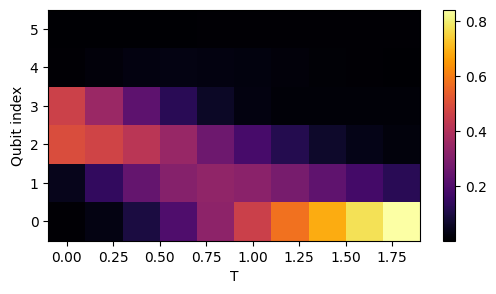

In [8]:
# For gamma = 0.5 case 
# (Full matrices and state vector based, no qiskit)
N = 6
nb_timesteps = 10
timestep_duration = 0.2
gamma = 0.5
J = 1

# Generate the unitary
matrix = get_U_HN(J, gamma , N, timestep_duration)
projection_matrix = projection(N+1)

# create the initial state vector (|↓↓↑↓↓↓⟩+|↓↓↓↑↓↓⟩)/ 2
initial_vector = np.zeros((2**(N+1), 1), dtype=complex)
initial_vector[ (2**N - 1) - 2**(N//2)] = 1/np.sqrt(2)
initial_vector[ (2**N - 1) - 2**(N//2 -1)] = 1/np.sqrt(2)

magnetization=[]
for n_steps in range(1, nb_timesteps + 1):

    # for each time step, apply the matrix n_steps times onto the initial vector
    state_vector = np.matmul(np.linalg.matrix_power(matrix @ projection_matrix, n_steps), initial_vector).T[0]
    state_dict = {}
    for i in range(2 ** (N+1)):

        # allocate the relevant probabilities to each state
        state_dict[bin(i)[2:].zfill(N+1)] = np.abs(state_vector[i]) ** 2

   
    # create a new row to add to magnetization array
    row = [0 for _ in range(N)]
    prob = 0
    for key, value in state_dict.items():

        # key[0] is the ancillary qubit
        if key[0] == '0':
            prob += value
            for i in range(1, N + 1):

                # if the other qubits have a result of 0, then add the probabilities to that qubit
                if key[i] == '0':
                    row[N - i] += value

    magnetization += [[x/prob for x in row]]

magnetization = np.array(magnetization)
print(magnetization.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

# Attempt 6: Using VQA -- adapting from attempt 2

In [9]:
int('0110111', 2)

55

(6, 10)


Text(0.5, 0, 'T')

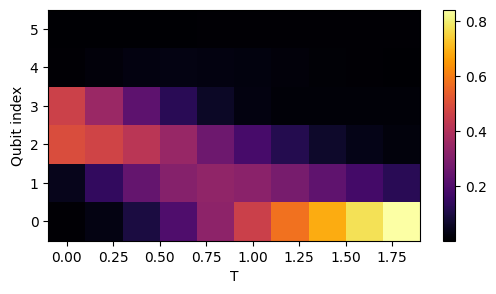

In [79]:
# For gamma = 0.5 case 
# (Full matrices and state vector based, no qiskit)
N = 6
nb_timesteps = 10
timestep_duration = 0.2
gamma = 0.5
J = 1

# Generate the unitary
matrix = get_U_HN(J, gamma , N, timestep_duration)
projection_matrix = projection(N+1)

# create the initial state vector (|↓↓↑↓↓↓⟩+|↓↓↓↑↓↓⟩)/ 2
initial_vector = np.zeros((2**(N+1), 1), dtype=complex)
initial_vector[ (2**N - 1) - 2**(N//2)] = 1/np.sqrt(2)
initial_vector[ (2**N - 1) - 2**(N//2 -1)] = 1/np.sqrt(2)

probabilities=[]
target_states = {}
for n_steps in range(0, nb_timesteps + 1):

    # for each time step, apply the matrix n_steps times onto the initial vector
    # state_vector = np.matmul(np.linalg.matrix_power(matrix @ projection_matrix , n_steps), initial_vector).T[0]
    state_vector = np.matmul(np.linalg.matrix_power(projection_matrix @ matrix, n_steps), initial_vector).T[0]
    state_dict = {}
    probs_dict = {}
    for i in range(2 ** (N+1)):

        # allocate the relevant probabilities to each state
        # to consider little endian of qiskit:
        string = bin(i)[2:].zfill(N+1)
        string = string[1:] + string[0]
        probs_dict[string] = np.abs(state_vector[i]) ** 2
    target_states[n_steps] = state_vector
   
    # create a new row to add to magnetization array
    row = [0 for _ in range(N)]
    prob = 0
    for key, value in probs_dict.items():

        # key[0] is the ancillary qubit
        if key[-1] == '0':
            prob += value
            for i in range(0, N):

                # if the other qubits have a result of 0, then add the probabilities to that qubit
                if key[i] == '0':
                    row[N - i - 1] += value
        #else:
        #    print(value)
    if n_steps > 0:
        probabilities += [[x/prob for x in row]]

probabilities = np.array(probabilities)
print(probabilities.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), probabilities.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

In [12]:
target_states[1]

array([ 0.00000000e+00+0.00000000e+00j,  2.76257667e-33+8.62179862e-34j,
        6.35582601e-33-9.75913700e-33j,  2.07065117e-17-6.86237833e-18j,
       -1.34004599e-31-8.77104993e-32j, -2.16132317e-18+1.04175907e-17j,
       -8.89788589e-19+1.41895480e-17j,  2.18766999e-17-2.57445304e-17j,
       -3.80556796e-32+5.06738084e-32j,  2.22429422e-17-1.81596171e-17j,
        2.48331264e-18+1.24746779e-17j,  3.13531072e-18+1.33272254e-17j,
        3.35977710e-17-2.09534959e-17j, -9.02869413e-17-1.09915920e-17j,
        5.82509270e-17+9.71508437e-17j, -2.98749777e-17-3.59918480e-17j,
       -4.34914790e-32+6.81011521e-33j,  4.28228124e-18+1.02857990e-17j,
       -1.53402179e-17+2.38987470e-17j,  9.46204740e-17-1.88540687e-17j,
        5.88180512e-19+5.31989667e-19j,  1.04394401e-17-4.20749924e-18j,
       -2.94201141e-17-6.14864086e-17j, -7.55411679e-18-3.33500436e-17j,
       -2.68562070e-18+1.20786245e-17j,  2.66909030e-17-1.09303122e-17j,
        9.95603657e-17+5.30953585e-17j,  8.58035721

In [13]:
def unitary_gate_matrix(theta, phi, lam):
    return np.array([[np.cos(theta/2), -np.exp(lam * 1j) * np.sin(theta/2)],
                    [np.exp(phi * 1j) * np.sin(theta/2), np.exp(1j * (phi + lam)) * np.cos(theta/2)]])

cx_matrix = np.array([[1, 0, 0, 0], 
                     [0, 0, 0, 1], 
                     [0, 0, 1, 0],
                     [0, 1, 0, 0]])

cx_matrices = np.kron(np.kron(cx_matrix, cx_matrix), cx_matrix)

cx_matrix_v1 = np.kron(np.eye(2), cx_matrices)
cx_matrix_v2 = np.kron(cx_matrices, np.eye(2))

In [68]:
def variational_circuit_mathematical(params):
    stepper = 0
    layers = 4

    #state = np.zeros((2**(N+1), 1), dtype=complex) #initial_vector.copy()
    #state = np.full((2**(N+1), 1), np.sqrt(1.0/2**(N+1)))
    state = np.zeros((2**(N+1), 1), dtype=complex)
    state[0] = 1
    #state = initial_vector.copy()

    
    matrix = unitary_gate_matrix(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2])
    stepper += 1
    for _ in range(N):
        matrix = np.kron(unitary_gate_matrix(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2]), matrix)
        stepper += 1
    state = np.matmul(matrix, state)


    for _ in range(layers):
        state = np.matmul(cx_matrix_v1, state)
        matrix = unitary_gate_matrix(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2])
        stepper += 1
        for _ in range(N - 1):
            matrix = np.kron(unitary_gate_matrix(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2]), matrix)
            stepper += 1
        matrix = np.kron(np.eye(2), matrix)
        state = np.matmul(matrix, state)
        state = np.matmul(cx_matrix_v1, state)

        state = np.matmul(cx_matrix_v2, state)
        matrix = np.eye(2)
        for _ in range(N):
            matrix = np.kron(unitary_gate_matrix(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2]), matrix)
            stepper += 1
        state = np.matmul(matrix, state)
        state = np.matmul(cx_matrix_v2, state)
    
    return state
        

In [55]:
def cost_function_math(params, n_steps):
    return 1 - np.abs(np.vdot(variational_circuit_mathematical(params), target_states[n_steps]))

In [67]:
def variational_circuit(params):
    qc = QuantumCircuit(N+1)
    stepper = 0
    layers = 4

    #qc.x([0, 1, 2, 5, 6])
    #qc.h(3)
    #qc.cx(3, 4)
    #qc.x(4)
    qc.h(range(N+1))

    # initial
    for qubit in range(N+1):
        qc.u(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2], qubit) #N - qubit)
        stepper += 1
    
    for layer in range(layers):
        # CX gates
        qc.cx(0, 1)
        qc.cx(2, 3)
        qc.cx(4, 5)

        # first set of U3 gates
        while qubit in range(N):
            qc.u(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2], qubit) #N - qubit - 1)
            stepper += 1
        
        # CX gates
        qc.cx(0, 1)
        qc.cx(2, 3)
        qc.cx(4, 5)

        # CX gates
        qc.cx(1, 2)
        qc.cx(3, 4)
        qc.cx(5, 6)

        # first set of U3 gates
        while qubit in range(N):
            qc.u(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2], qubit + 1) #N - qubit)
            stepper += 1
        
        # CX gates
        qc.cx(1, 2)
        qc.cx(3, 4)
        qc.cx(5, 6)

    qc.measure_all()

    return qc

In [17]:
def calculate_results(params):

    # initialization of the sampler
    sampler = Sampler(mode=BACKEND)
    
    # Sampler runs a job on the Bell circuit
    job = sampler.run([(variational_circuit(params))])
    job_result = job.result()
    return job_result[0].data.meas.get_counts(), job_result[0].metadata['shots']

In [69]:
params0 = np.array([0.0 for i in range(((N+1) + (N * 2 * 8)) * 3)])
params_test = np.array([np.pi/4 for i in range(((N+1) + (N * 2 * 4)) * 3)])
bounds = tuple([(0.0, np.pi) if i % 3 == 0 else (0.0, 2 * np.pi) for i in range(((N+1) + (N * 2 * 4)) * 3)])

In [83]:
res = minimize(cost_function_math, params_test, args=1, method='L-BFGS-B', options={'maxfun': 100000})
print(cost_function_math(res.x, 1))
print(res.message)

0.2863900914588522
CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL


In [20]:
res = minimize(cost_function_math, params0, args=5, method='COBYLA', options={'ftol': 1E-2, 'gtol': 1E-2, 'maxfun': 10000, 'maxiter': 10000})

/var/folders/x8/z2s685412c74m1sp9myb1f_m0000gn/T/ipykernel_13791/3763937216.py:1: OptimizeWarning: Unknown solver options: ftol, gtol, maxfun
  res = minimize(cost_function_math, params0, args=5, method='COBYLA', options={'ftol': 1E-2, 'gtol': 1E-2, 'maxfun': 10000, 'maxiter': 10000})


In [34]:
res = minimize(cost_function_math, params0, args=2, method='COBYLA')
print(cost_function_math(res.x, 2))


0.32743958597124956


np.float64(0.022601649503391386)

In [ ]:
res = minimize(cost_function_math, params0, args=5, method='L-BFGS-B', options={'ftol': 1E-6, 'gtol': 1E-6, 'maxfun': 100000, 'maxiter': 100000})

In [ ]:
res = minimize(cost_function_math, params0, args=5, method='BFGS', bounds=bounds)
print(cost_function_math(res.x, 5))
print(res.message)

/var/folders/x8/z2s685412c74m1sp9myb1f_m0000gn/T/ipykernel_13791/356612249.py:1: RuntimeWarning: Method BFGS cannot handle bounds.
  res = minimize(cost_function_math, params0, args=5, method='BFGS', bounds=bounds)


0.68480195931655
Optimization terminated successfully.


In [ ]:
res = minimize(cost_function_math, params0, args=5, method='CG', bounds=bounds)
print(cost_function_math(res.x, 5))
print(res.message)

/var/folders/x8/z2s685412c74m1sp9myb1f_m0000gn/T/ipykernel_13791/3674822526.py:1: RuntimeWarning: Method CG cannot handle bounds.
  res = minimize(cost_function_math, params0, args=5, method='CG', bounds=bounds)


KeyboardInterrupt: 

In [35]:
res = minimize(cost_function_math, params0, args=5, method='trust-constr', bounds=bounds)
print(cost_function_math(res.x, 5))
print(res.message)

0.6848005104489631
The maximum number of function evaluations is exceeded.


In [37]:
res = minimize(cost_function_math, params0, args=5, method='L-BFGS-B', bounds=bounds)
print(cost_function_math(res.x, 5))
print(res.message)

1.0
CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL


In [24]:
cost_function_math(res.x, 5)

np.float64(0.701591775142134)

In [25]:
res.message

'STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT'

In [ ]:
variational_circuit_mathematical(res.x)

array([[ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.   

In [ ]:
calculate_results(res.x)

({'1101111': 506, '1110111': 518}, 1024)

In [ ]:
for n_steps in range(1, nb_timesteps + 1):
    print(n_steps, cost_function_math(params_dict[n_steps], n_steps))

1 0.29617039602269846
2 0.4969641295539149
3 0.618768137123683
4 0.6956275354491153
5 0.7824447178677582
6 0.8131387265780704
7 0.8549012848066042
8 0.8886303657688782
9 0.9190735416428899
10 0.9362521314525583


In [ ]:
params_dict = {}
for n_steps in range(1, nb_timesteps + 1):
    print("Step number: ", n_steps)
    res = minimize(cost_function_math, params0, args=n_steps, method='L-BFGS-B', options={'ftol': 1E-10, 'gtol': 1E-10, 'maxfun': 100000, 'maxiter': 100000})
    print(cost_function_math(res.x, n_steps))

    params_dict[n_steps] = res.x

Step number:  1


KeyboardInterrupt: 

{'0000000': 861, '0000001': 106, '0010001': 1, '0000100': 30, '0010000': 10, '0100000': 8, '0100001': 2, '0000101': 3, '0001000': 2, '0011001': 1}
{'0000000': 674, '0010000': 171, '0000001': 63, '0110000': 3, '0000100': 12, '0010100': 1, '0010001': 15, '0001000': 63, '0011000': 14, '0100001': 2, '0011001': 2, '0100000': 2, '0001001': 2}
{'0000000': 841, '0001001': 2, '0010000': 91, '0000001': 55, '0000010': 2, '0010001': 8, '0000100': 6, '0001000': 13, '0000101': 2, '0011000': 3, '0011001': 1}
{'0000000': 951, '0000001': 31, '0000010': 17, '0100000': 20, '0000100': 1, '0100010': 1, '0001000': 3}
{'0000000': 491, '0000100': 281, '0000001': 121, '0000101': 72, '0010101': 1, '0010100': 7, '0100100': 1, '0000010': 7, '0001000': 8, '0010010': 1, '0001101': 2, '0010001': 5, '0001100': 5, '0100000': 1, '0010000': 7, '0011100': 1, '0010011': 1, '0000110': 3, '0000011': 4, '0100001': 1, '0000111': 2, '0100010': 1, '0001001': 1}
{'0000000': 572, '0000100': 310, '0010000': 52, '0000001': 16, '000

Text(0.5, 0, 'T')

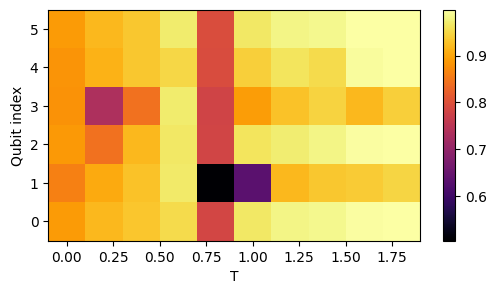

In [115]:
res_all_circuits = []
for n_steps in range(1, nb_timesteps + 1):
    res, counts = calculate_results(params_dict[n_steps])
    print(res)

    # create a new row to add to magnetization array
    row = [0 for _ in range(N)]
    prob = 0
    for key, value in res.items():

        prob += value
        if key[-1] == "0":
            for i in range(0, N):

                # if the other qubits have a result of 0, then add the probabilities to that qubit
                if key[i] == '0':
                    row[N - i - 1] += value

    res_all_circuits += [[x/prob for x in row]]

res_all_circuits = np.array(res_all_circuits)

print(res_all_circuits.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), res_all_circuits.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

In [16]:
np.matmul(np.linalg.matrix_power(projection_matrix @ matrix, 1), initial_vector).T[0]

array([ 0.00000000e+00+0.00000000e+00j,  6.68492214e-34-1.23646945e-33j,
       -6.14729885e-33-6.14631197e-33j, -3.65663430e-17-1.47733922e-18j,
       -2.41749208e-32+2.81676371e-32j,  5.86039017e-18-1.73215912e-17j,
        7.37736743e-17+5.86890666e-20j, -3.83168146e-17+9.77550505e-18j,
        1.18042628e-32-2.04857537e-32j, -1.04031957e-16+7.40530335e-19j,
        9.97291319e-19-1.68220226e-17j, -8.01116363e-18-2.62968650e-17j,
       -1.29506937e-16-5.27060589e-17j, -6.68703656e-18+3.32003294e-17j,
       -3.35724722e-17+3.88982483e-17j,  6.70676277e-17+3.85945414e-18j,
       -3.79445119e-32-2.97715087e-32j,  1.02275651e-18-3.86313951e-17j,
        1.08697190e-16+5.11808955e-17j,  2.26684683e-17-2.99485655e-17j,
        1.25945809e-18-1.63621215e-17j,  1.69765803e-17-2.61242980e-17j,
        3.92886838e-17+5.31118782e-18j, -1.61521316e-17+3.07034212e-17j,
        7.12109414e-17-6.57437565e-18j, -1.51443582e-17-7.47633732e-18j,
       -3.01827912e-17-4.69342595e-17j, -7.15895560

In [42]:
# For gamma = 0.5 case 
# (Full matrices and state vector based, no qiskit)
N = 6
nb_timesteps = 10
timestep_duration = 0.2
gamma = 0.5
J = 1

# Generate the unitary
matrix = get_U_HN(J, gamma , N, timestep_duration)
projection_matrix = projection(N+1)

# create the initial state vector (|↓↓↑↓↓↓⟩+|↓↓↓↑↓↓⟩)/ 2
initial_vector = np.zeros((2**(N+1), 1), dtype=complex)
initial_vector[ (2**N - 1) - 2**(N//2)] = 1/np.sqrt(2)
initial_vector[ (2**N - 1) - 2**(N//2 -1)] = 1/np.sqrt(2)

states_all_circuits={}
target_states = {}
for n_steps in range(0, nb_timesteps + 1):

    # for each time step, apply the matrix n_steps times onto the initial vector
    state_vector = np.matmul(np.linalg.matrix_power(projection_matrix @ matrix, n_steps), initial_vector).T[0]
    state_dict = {}
    for i in range(2 ** (N+1)):
 
        # allocate the relevant quasi-probabilities to each state
        # state_dict[bin(i)[2:].zfill(N+1)] = np.abs(state_vector[i]) ** 2

        # original version:
        # state_dict[bin(i)[2:].zfill(N+1)] = state_vector[i]

        # to consider little endian of qiskit:
        string = bin(i)[2:].zfill(N+1)
        string = string[1:] + string[0]
        state_dict[string] = state_vector[i]
    
    states_all_circuits[n_steps] = state_dict
    target_states[n_steps] = state_vector



'''
    # create a new row to add to magnetization array
    row = [0 for _ in range(N)]
    prob = 0
    for key, value in state_dict.items():

        prob += value
        for i in range(1, N + 1):

            # if the other qubits have a result of 0, then add the probabilities to that qubit
            if key[i] == '0':
                row[N - i] += value

    states += [[x/prob for x in row]]

states = np.array(states)

print(states.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), states.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

'''

"\n    # create a new row to add to magnetization array\n    row = [0 for _ in range(N)]\n    prob = 0\n    for key, value in state_dict.items():\n\n        prob += value\n        for i in range(1, N + 1):\n\n            # if the other qubits have a result of 0, then add the probabilities to that qubit\n            if key[i] == '0':\n                row[N - i] += value\n\n    states += [[x/prob for x in row]]\n\nstates = np.array(states)\n\nprint(states.T.shape)\nfig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')\nim = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), states.T, cmap='inferno')\nfig.colorbar(im)\nplt.ylabel('Qubit index')\nplt.xlabel('T')\n\n"

In [44]:
print(target_states[0])

[0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.70710678+0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.70710678+0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.      

In [43]:
print(states_all_circuits[n_steps])

{'0000000': np.complex128(0j), '0000010': np.complex128(-1.2593500593537499e-33-5.324763759369562e-34j), '0000100': np.complex128(-3.9318164475760835e-35-2.722562159108676e-33j), '0000110': np.complex128(-6.430346891187752e-18-7.796849959600846e-19j), '0001000': np.complex128(-1.388976185959808e-32+1.2716789820244084e-34j), '0001010': np.complex128(-7.238540076201779e-19-5.238954438869388e-18j), '0001100': np.complex128(1.1372899201958289e-17-5.4972921170525286e-18j), '0001110': np.complex128(4.5890883315416094e-18+1.1488660715974069e-18j), '0010000': np.complex128(8.608042217199362e-33+1.8826528361686297e-33j), '0010010': np.complex128(-1.7523624283815716e-17-4.932861335285801e-18j), '0010100': np.complex128(1.233158598865033e-17-2.2641656869870472e-17j), '0010110': np.complex128(-7.523643610055412e-20+1.2957633205269557e-17j), '0011000': np.complex128(-3.2381931639548666e-18-2.3392122364055947e-18j), '0011010': np.complex128(3.4036629466173244e-18-2.022837534154405e-18j), '0011100': 

In [19]:
print(initial_vector)

[[0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.        +0.j]
 [0.707106

In [16]:
def unitary_gate_matrix(theta, phi, lam):
    return np.array([[np.cos(theta/2), -np.exp(lam * 1j) * np.sin(theta/2)],
                    [np.exp(phi * 1j) * np.sin(theta/2), np.exp(1j * (phi + lam)) * np.cos(theta/2)]])

In [194]:
cx_matrix = np.array([[1, 0, 0, 0], 
                     [0, 0, 0, 1], 
                     [0, 0, 1, 0],
                     [0, 1, 0, 0]])

cx_matrices = np.kron(np.kron(cx_matrix, cx_matrix), cx_matrix)

cx_matrix_v1 = np.kron(np.eye(2), cx_matrices)
cx_matrix_v2 = np.kron(cx_matrices, np.eye(2))

In [195]:
def variational_circuit_mathematical(params):
    stepper = 0
    layers = 8 

    #state = np.zeros((2**(N+1), 1), dtype=complex) #initial_vector.copy()
    state = np.full((2**(N+1), 1), np.sqrt(1.0/2**(N+1)))

    
    matrix = unitary_gate_matrix(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2])
    stepper += 1
    for _ in range(N):
        matrix = np.kron(unitary_gate_matrix(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2]), matrix)
        stepper += 1
    state = np.matmul(matrix, state)
    # print(state, matrix)

    


    for _ in range(layers):
        state = np.matmul(cx_matrix_v1, state)
        matrix = unitary_gate_matrix(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2])
        stepper += 1
        for _ in range(N - 1):
            matrix = np.kron(unitary_gate_matrix(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2]), matrix)
            stepper += 1
        matrix = np.kron(np.eye(2), matrix)
        state = np.matmul(matrix, state)
        state = np.matmul(cx_matrix_v1, state)

        state = np.matmul(cx_matrix_v2, state)
        matrix = np.eye(2)
        for _ in range(N):
            matrix = np.kron(unitary_gate_matrix(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2]), matrix)
            stepper += 1
        state = np.matmul(matrix, state)
        state = np.matmul(cx_matrix_v2, state)
    
    return state
        



    


In [ ]:
def cost_function_math(params, n_steps):
    return 1 - np.abs(np.vdot(variational_circuit_mathematical(params), target_states[n_steps]))

In [201]:
def variational_circuit(params):
    qc = QuantumCircuit(N+1)
    stepper = 0
    layers = 8

    # qc.x(range(1, 3))
    # qc.x(range(5, N+1))
    # qc.h(3)
    # qc.cx(3, 4)
    # qc.x(4)

    # initial
    for qubit in range(N+1):
        qc.u(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2], qubit) #N - qubit)
        stepper += 1
    
    for layer in range(layers):
        # CX gates
        qc.cx(0, 1)
        qc.cx(2, 3)
        qc.cx(4, 5)

        # first set of U3 gates
        while qubit in range(N):
            qc.u(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2], qubit) #N - qubit - 1)
            stepper += 1
        
        # CX gates
        qc.cx(0, 1)
        qc.cx(2, 3)
        qc.cx(4, 5)

        # CX gates
        qc.cx(1, 2)
        qc.cx(3, 4)
        qc.cx(5, 6)

        # first set of U3 gates
        while qubit in range(N):
            qc.u(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2], qubit + 1) #N - qubit)
            stepper += 1
        
        # CX gates
        qc.cx(1, 2)
        qc.cx(3, 4)
        qc.cx(5, 6)

    qc.measure_all()

    return qc

In [ ]:
def cost_function_math(params, n_steps):
    return 1 - np.abs(np.vdot(variational_circuit_mathematical(params), target_states[n_steps]))

In [ ]:
randoms = np.random.rand(((N+1) + (N * 2 * 8)) * 3)
params0 = np.array([0.0 for i in randoms])
params0 = np.array([0.0 for i in range(((N+1) + (N * 2 * 8)) * 3)])

In [136]:
print(variational_circuit_mathematical(params15))

[[-0.0268373 -0.11977162j]
 [-0.02404712-0.10416593j]
 [-0.05133136-0.0963814j ]
 [-0.03701344-0.1000026j ]
 [-0.0345589 -0.10068856j]
 [-0.03220705-0.08736584j]
 [-0.04103941-0.06974347j]
 [-0.02881409-0.0728069j ]
 [-0.04814316-0.09570284j]
 [-0.0422115 -0.08295485j]
 [-0.0650555 -0.07324257j]
 [-0.05360015-0.07959472j]
 [-0.04619099-0.09635643j]
 [-0.04231876-0.08353932j]
 [-0.05002839-0.06315833j]
 [-0.03837311-0.06760128j]
 [-0.03558643-0.10147404j]
 [-0.03165008-0.08812664j]
 [-0.05353865-0.07849652j]
 [-0.04139482-0.08303399j]
 [-0.04081758-0.08509083j]
 [-0.0372762 -0.07366866j]
 [-0.04445564-0.05727053j]
 [-0.03407481-0.06131411j]
 [-0.04095108-0.07113949j]
 [-0.03576933-0.06170873j]
 [-0.05403993-0.05331706j]
 [-0.04561774-0.05875374j]
 [-0.03907978-0.07051757j]
 [-0.03569587-0.06098333j]
 [-0.03939262-0.04510688j]
 [-0.0307558 -0.04887972j]
 [-0.03494545-0.08622612j]
 [-0.03089492-0.07492051j]
 [-0.05065251-0.06572315j]
 [-0.04041354-0.07023218j]
 [-0.03820002-0.07069335j]
 

In [113]:
cost_function_math(params0, 0)

np.float64(1.0)

In [197]:
res = minimize(cost_function_math, params0, args=0, method='L-BFGS-B')

In [198]:
cost_function_math(res.x, 0)

np.float64(3.6617020526819033e-10)

In [162]:
np.abs(np.vdot(variational_circuit_mathematical(res.x), target_states[0]))

np.float64(0.9999999692595366)

In [144]:
target_states[0]

array([0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.70710678+0.j,
      

In [ ]:
cost_function_math(res.x, 0)
variational_circuit_mathematical(res.x)
calculate_results(res.x)

array([[ 4.62121682e-12+0.j],
       [ 1.26226798e-11+0.j],
       [-4.65096412e-12+0.j],
       [-2.09207001e-06+0.j],
       [ 1.85490080e-11+0.j],
       [-2.48189182e-11+0.j],
       [-5.35504130e-11+0.j],
       [-4.78588770e-06+0.j],
       [ 1.16795015e-11+0.j],
       [ 4.95437971e-11+0.j],
       [ 5.06899845e-11+0.j],
       [-3.65400955e-06+0.j],
       [-6.53134612e-12+0.j],
       [ 3.29470556e-12+0.j],
       [-4.79615025e-12+0.j],
       [ 2.09209074e-06+0.j],
       [ 6.28093441e-13+0.j],
       [-2.31711706e-12+0.j],
       [ 1.59453974e-12+0.j],
       [-3.26557792e-08+0.j],
       [-5.31609984e-12+0.j],
       [-4.64060571e-12+0.j],
       [ 1.68317887e-12+0.j],
       [ 1.41163110e-06+0.j],
       [-4.30664115e-12+0.j],
       [-2.93396634e-12+0.j],
       [-1.16231759e-12+0.j],
       [ 1.40958555e-06+0.j],
       [-6.50449774e-13+0.j],
       [-3.98399737e-12+0.j],
       [ 2.46076008e-12+0.j],
       [ 3.26425309e-08+0.j],
       [ 1.96113965e-11+0.j],
       [ 6

In [200]:
calculate_results(res.x)

({'0000000': 954, '0000001': 6, '1000000': 42, '0010000': 20, '0100000': 2},
 1024)

In [116]:
params15 = np.array([1.5 for i in randoms])

In [158]:
res = minimize(cost_function_math, params15, args=0, method='L-BFGS-B', bounds=bounds)

In [118]:
cost_function_math(res.x, 0)

np.float64(1.0)

In [159]:
res.x

array([1.52332992, 1.55807298, 1.46133682, 1.48692098, 1.37831664,
       1.26445733, 1.50304862, 1.54194319, 1.48446001, 1.51074867,
       1.49877614, 1.43929222, 1.50785538, 1.4947358 , 1.33021742,
       1.49446477, 1.41790189, 1.64188773, 1.50496539, 1.48364983,
       1.70364395, 1.4975709 , 1.54277306, 1.54122019, 1.50912389,
       1.50524038, 1.5419453 , 1.48886096, 1.55578231, 1.63009698,
       1.52106757, 1.65304682, 1.49473601, 1.51004718, 1.33042606,
       1.45335428, 1.44577804, 1.30715548, 1.48364983, 1.49209242,
       1.75343398, 1.47884007, 1.46336045, 1.30531077, 1.37557357,
       1.50121836, 1.55098766, 1.56879546, 1.47588992, 1.51182344,
       1.5218365 , 1.4702876 , 1.49355981, 1.54788482, 1.48748815,
       1.4919585 , 1.42324707, 1.46569529, 1.48809896, 1.54310038,
       1.47276227, 1.56511606, 1.52680875, 1.53101697, 1.48012899,
       1.56700153, 1.54714757, 1.48523467, 1.44581286, 1.47029076,
       1.43116652, 1.58442146, 1.57043157, 1.50606114, 1.30715

In [160]:
variational_circuit_mathematical(res.x)

array([[ 2.03913701e-05+1.29274102e-04j],
       [-7.61318043e-06-2.85847061e-04j],
       [ 1.50952414e-05-4.58367355e-05j],
       [ 6.69788651e-05-1.15807832e-03j],
       [ 6.34130830e-05-1.49085878e-05j],
       [-1.38642858e-04-3.60542510e-06j],
       [-8.03121853e-06+6.81899878e-05j],
       [ 7.08106220e-04+1.80759402e-04j],
       [-1.72192834e-05+1.13203205e-05j],
       [-3.96577609e-05+1.04424663e-04j],
       [-2.00163290e-05-5.19663137e-05j],
       [-6.37547228e-04-2.05586610e-04j],
       [ 4.71440876e-04+1.75564544e-04j],
       [-4.69363240e-04-2.60106211e-04j],
       [-2.13201727e-04+5.24710243e-05j],
       [-5.91290517e-04-1.92613760e-04j],
       [-9.47101140e-04+4.66401750e-05j],
       [-4.11459554e-04-2.03381328e-04j],
       [ 2.00675134e-04-2.96336920e-04j],
       [ 5.84049632e-04-8.08310033e-04j],
       [-2.90603339e-04-1.13572927e-05j],
       [ 6.11595974e-05+1.14841133e-04j],
       [ 5.62157527e-05-7.68540509e-05j],
       [ 2.44018328e-05-1.84986224

In [96]:
res.x

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [203]:
calculate_results(res.x)

({'0000000': 954,
  '0000001': 5,
  '1000000': 37,
  '1000001': 1,
  '0010000': 26,
  '1010000': 1},
 1024)

In [171]:
variational_circuit_mathematical(res.x)

array([[ 8.32091930e-12+0.j],
       [ 1.01104866e-11+0.j],
       [-6.02692082e-12+0.j],
       [ 3.32786847e-07+0.j],
       [-7.18673527e-11+0.j],
       [-1.48400741e-10+0.j],
       [ 7.01452115e-11+0.j],
       [-1.14810706e-05+0.j],
       [-6.48708009e-11+0.j],
       [-1.56248993e-10+0.j],
       [ 7.14987208e-11+0.j],
       [-1.17011723e-05+0.j],
       [-8.55358057e-12+0.j],
       [-9.83860029e-12+0.j],
       [ 5.99139301e-12+0.j],
       [-3.14330820e-07+0.j],
       [-3.38368583e-11+0.j],
       [-8.32398328e-11+0.j],
       [ 3.84969186e-11+0.j],
       [-5.98396069e-06+0.j],
       [ 3.78808240e-09+0.j],
       [ 5.78315073e-10+0.j],
       [-3.50977162e-11+0.j],
       [ 6.10600521e-06+0.j],
       [-3.71520006e-09+0.j],
       [-4.16690524e-10+0.j],
       [-3.92916375e-11+0.j],
       [ 6.13700103e-06+0.j],
       [-2.66332124e-11+0.j],
       [-6.53695222e-11+0.j],
       [ 2.98622843e-11+0.j],
       [-5.26843077e-06+0.j],
       [ 1.39314797e-10+0.j],
       [ 3

In [52]:
cost_function_math(params0, 1)

np.float64(0.3078281031951122)

In [168]:
def variational_circuit(params):
    qc = QuantumCircuit(N+1)
    stepper = 0
    layers = 8

    # qc.x(range(1, 3))
    # qc.x(range(5, N+1))
    # qc.h(3)
    # qc.cx(3, 4)
    # qc.x(4)

    # initial
    for qubit in range(N+1):
        qc.u(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2], qubit) #N - qubit)
        stepper += 1
    
    for layer in range(layers):
        # CX gates
        qc.cx(0, 1)
        qc.cx(2, 3)
        qc.cx(4, 5)

        # first set of U3 gates
        while qubit in range(N):
            qc.u(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2], qubit) #N - qubit - 1)
            stepper += 1
        
        # CX gates
        qc.cx(0, 1)
        qc.cx(2, 3)
        qc.cx(4, 5)

        # CX gates
        qc.cx(1, 2)
        qc.cx(3, 4)
        qc.cx(5, 6)

        # first set of U3 gates
        while qubit in range(N):
            qc.u(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2], qubit + 1) #N - qubit)
            stepper += 1
        
        # CX gates
        qc.cx(1, 2)
        qc.cx(3, 4)
        qc.cx(5, 6)

    qc.measure_all()

    return qc




In [ ]:
res_all_circuits = []
for n_steps in range(1, nb_timesteps + 1):
    res, counts = calculate_results(params_dict[n_steps])

    # create a new row to add to magnetization array
    row = [0 for _ in range(N)]
    prob = 0
    for key, value in res.items():

        prob += value
        if key[0] == "0":
            for i in range(1, N+1):

                # if the other qubits have a result of 0, then add the probabilities to that qubit
                if key[i] == '0':
                    row[N - i] += value

    res_all_circuits += [[x/prob for x in row]]

res_all_circuits = np.array(res_all_circuits)

print(res_all_circuits.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), res_all_circuits.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

In [202]:
def calculate_results(params):

    # initialization of the sampler
    sampler = Sampler(mode=BACKEND)
    
    # Sampler runs a job on the Bell circuit
    job = sampler.run([(variational_circuit(params))])
    job_result = job.result()
    return job_result[0].data.meas.get_counts(), job_result[0].metadata['shots']

In [22]:
def cost_function(params, n_steps):
    results, shots = calculate_results(params)
    sum = 0
    for key in results:
        sum += np.conj(np.sqrt(results[key]/shots)) * states_all_circuits[n_steps][key]

    return 1 - np.abs(sum)

In [ ]:
# scipy
# matrix product state

In [23]:
cost_function(np.ones((((N+1) + (N * 2 * 8)) * 3)), 8)

np.float64(0.9743571287872698)

In [97]:
#params0 = np.ones((((N+1) + (N * 2 * 8)) * 3))
#params0 = np.([np.pi for _ in range(((N+1) + (N * 2 * 8)) * 3)])
randoms = np.random.rand(((N+1) + (N * 2 * 8)) * 3)
# params0 = np.array([i * np.pi if i % 3 == 0 else i * 2 * np.pi for i in randoms])
params0 = np.array([0.0 for i in randoms])
bounds = tuple([(0.0, np.pi) if i % 3 == 0 else (0.0, 2 * np.pi) for i in range(((N+1) + (N * 2 * 8)) * 3)])
print(len(params0))



309


In [25]:
calculate_results(params0)

({'1110110': 523, '1101110': 501}, 1024)

In [26]:
cost_function(params0, 1)

np.float64(0.30839398700636655)

In [27]:
states_all_circuits[1]

{'0000000': np.complex128(0j),
 '0000010': np.complex128(6.6849221376257205e-34-1.2364694548330462e-33j),
 '0000100': np.complex128(-6.1472988499879264e-33-6.1463119726443224e-33j),
 '0000110': np.complex128(-3.656634295632328e-17-1.4773392172026571e-18j),
 '0001000': np.complex128(-2.4174920754563553e-32+2.816763709638737e-32j),
 '0001010': np.complex128(5.860390171003141e-18-1.732159122539683e-17j),
 '0001100': np.complex128(7.377367426354249e-17+5.868906661202172e-20j),
 '0001110': np.complex128(-3.831681464058006e-17+9.77550504970931e-18j),
 '0010000': np.complex128(1.1804262793123828e-32-2.0485753733866243e-32j),
 '0010010': np.complex128(-1.0403195734203423e-16+7.405303349052455e-19j),
 '0010100': np.complex128(9.972913194497789e-19-1.6822022628338232e-17j),
 '0010110': np.complex128(-8.01116363418184e-18-2.6296864965152372e-17j),
 '0011000': np.complex128(-1.2950693676146772e-16-5.2706058936558096e-17j),
 '0011010': np.complex128(-6.687036564712445e-18+3.320032944839262e-17j),
 

In [149]:
res = minimize(cost_function_math, params0, args=2, method='COBYLA')
# L-BFGS-B

In [150]:
print(res.x)
print(res.success)
print(res.message)
print(variational_circuit_mathematical(res.x))
print(cost_function_math(res.x, 0))
print(calculate_results(res.x))

[ 1.50155177e+00 -4.76516908e-01  3.01170673e-01  1.39641978e+00
  3.06428719e-01  1.03964069e-01  1.77918299e-01  5.02913775e-02
 -9.74253102e-02 -3.80064675e-02  9.77517398e-01 -5.88782946e-02
  1.02961396e+00 -4.98678689e-01 -6.93349087e-02  9.78004360e-01
  6.76446292e-01 -5.00781838e-01 -4.51000963e-01  7.65483177e-02
  1.53457005e-01  7.13078025e-02  1.30492474e+00 -9.00330344e-01
  4.22754968e-02  1.00269120e+00 -3.08687241e-03  7.10934808e-03
 -8.33445344e-02 -6.24158420e-02 -1.51365637e-03 -3.68558808e-01
  3.54283289e-01  9.22964324e-01  4.00354286e-01  6.12819707e-02
 -4.34773986e-01 -3.79325526e-02 -3.83696524e-01  6.02689350e-03
  1.02809766e+00 -1.37985721e-01  6.57154429e-03  1.16648135e+00
  8.56686673e-01  1.07696750e+00  4.57730739e-01  2.44574017e-01
  3.10871262e-01  1.90575668e-01  1.33445048e-01  2.17503392e-01
  4.88432984e-01  4.55878760e-01  2.45437415e-01  1.04362278e+00
  5.62493711e-02  1.02357541e-02 -3.67253462e-01 -3.63892063e-01
  5.08689497e-03 -1.12867

In [191]:
res = minimize(cost_function_math, params0, args=0, method='L-BFGS-B')

In [192]:
calculate_results(res.x)

({'0000000': 954,
  '1000000': 18,
  '0100000': 9,
  '0000010': 29,
  '0000001': 1,
  '0010000': 13},
 1024)

In [193]:
variational_circuit_mathematical(res.x)

array([[ 6.20761785e-13+0.j],
       [-3.83811180e-11+0.j],
       [-8.10976301e-13+0.j],
       [-1.51064555e-07+0.j],
       [ 3.42722487e-11+0.j],
       [-2.51109442e-11+0.j],
       [-3.72270838e-11+0.j],
       [-8.33821223e-06+0.j],
       [ 3.27177841e-11+0.j],
       [-4.56871451e-11+0.j],
       [-3.55387355e-11+0.j],
       [-7.96004944e-06+0.j],
       [-6.20715251e-13+0.j],
       [ 3.62584743e-11+0.j],
       [ 8.04822285e-13+0.j],
       [ 1.51064353e-07+0.j],
       [ 3.68100373e-12+0.j],
       [-3.33555310e-11+0.j],
       [-4.10171353e-12+0.j],
       [-8.95653605e-07+0.j],
       [ 2.57654726e-11+0.j],
       [ 1.39742673e-08+0.j],
       [-2.78482501e-11+0.j],
       [-6.25336314e-06+0.j],
       [ 2.70550175e-11+0.j],
       [-1.40327547e-08+0.j],
       [-2.95344986e-11+0.j],
       [-6.59751263e-06+0.j],
       [ 4.98491183e-12+0.j],
       [ 2.59107605e-11+0.j],
       [-5.30750330e-12+0.j],
       [-1.21283120e-06+0.j],
       [-1.52783597e-11+0.j],
       [ 3

In [63]:
print(res.x)
print(res.success)
print(res.message)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
True
CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL


In [47]:
res = minimize(cost_function_math, params0, args=3, method='L-BFGS-B', bounds=bounds)

KeyboardInterrupt: 

In [188]:
print(calculate_results(params_dict[1]))
print(variational_circuit_mathematical(params_dict[1]))

({'0000010': 80, '0000001': 58, '0010001': 51, '0110001': 33, '0010000': 52, '0100011': 45, '0010010': 82, '0000011': 95, '0011011': 5, '0100010': 34, '1010011': 10, '1100000': 4, '0011001': 5, '1010010': 4, '0001011': 10, '0010011': 82, '1000001': 9, '1000010': 14, '0100000': 35, '0100001': 38, '1110001': 2, '0110011': 41, '1100011': 8, '0110000': 33, '0110010': 53, '0000000': 61, '1010000': 7, '1010001': 5, '0011010': 3, '0101001': 1, '1001000': 2, '1111010': 1, '1110000': 4, '1100010': 7, '1100001': 2, '1000011': 8, '1001010': 1, '0101011': 2, '1110010': 5, '0001000': 2, '0111010': 5, '0001001': 3, '0111001': 7, '0001010': 3, '1001011': 1, '0111000': 1, '0011000': 3, '1000000': 3, '1110011': 1, '1011001': 1, '1011010': 1, '0111011': 1}, 1024)
[[ 6.99761850e-04-4.61674524e-04j]
 [ 4.79034687e-03-1.72461584e-03j]
 [ 6.85902019e-04+6.88948395e-04j]
 [ 7.81645946e-03-1.04690024e-02j]
 [ 1.50594451e-03+2.55100498e-03j]
 [-3.82498381e-03+8.32014773e-04j]
 [-6.07526244e-04+1.18325292e-04j]

In [204]:
params_dict = {}
for n_steps in range(1, nb_timesteps + 1):
    print("Step number: ", n_steps)
    res = minimize(cost_function_math, params0, args=n_steps, method='COBYLA')

    params_dict[n_steps] = res.x

Step number:  1
Step number:  2
Step number:  3
Step number:  4
Step number:  5
Step number:  6
Step number:  7
Step number:  8
Step number:  9
Step number:  10


In [176]:
params_dict

{1: array([ 1.07474694,  0.79179107, -0.08872492,  1.3967672 ,  0.60343786,
        -0.15884273, -0.0199344 , -0.02355608, -0.03049922, -0.18144295,
        -0.34562365, -0.16424161,  0.93139052,  0.23663042, -0.13965923,
         0.88833492,  0.61089878, -0.06234354, -1.06766308,  0.38719423,
        -0.04337425,  0.0714234 ,  0.39775894, -0.0223952 , -0.01851106,
        -0.07490251, -0.0616688 ,  0.00569294, -0.10124766, -0.10739012,
         1.25367223,  0.84722765, -0.03202431,  0.04804029,  1.33716571,
         0.99888161,  0.0033874 ,  0.02838205,  0.02996523, -0.24378038,
         0.97039994,  1.01354926, -0.09973919,  1.31271225, -0.13590873,
         1.0020807 , -0.63832245,  0.35275087,  0.34173106,  0.03243563,
         0.635074  ,  1.02417974,  0.21193369,  0.27434778,  0.32536118,
        -0.26110705,  0.25225535,  0.3353611 , -0.31836121,  0.59350003,
         0.30788723,  0.96432538,  0.34010298,  0.28822529,  0.28456615,
         0.21655375,  0.28382465,  1.6066159 ,  

(6, 10)


Text(0.5, 0, 'T')

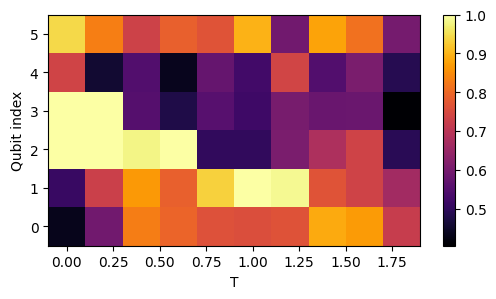

In [205]:
res_all_circuits = []
for n_steps in range(1, nb_timesteps + 1):
    res, counts = calculate_results(params_dict[n_steps])

    # create a new row to add to magnetization array
    row = [0 for _ in range(N)]
    prob = 0
    for key, value in res.items():

        prob += value
        if key[0] == "0":
            for i in range(1, N+1):

                # if the other qubits have a result of 0, then add the probabilities to that qubit
                if key[i] == '0':
                    row[N - i] += value

    res_all_circuits += [[x/prob for x in row]]

res_all_circuits = np.array(res_all_circuits)

print(res_all_circuits.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), res_all_circuits.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

(6, 10)


Text(0.5, 0, 'T')

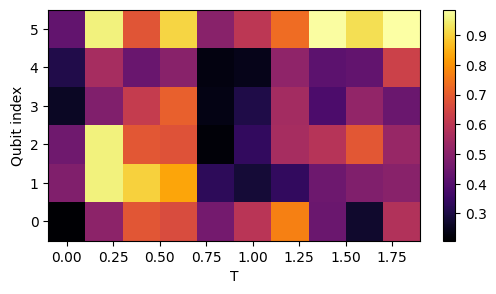

In [189]:
res_all_circuits = []
for n_steps in range(1, nb_timesteps + 1):
    res, counts = calculate_results(params_dict[n_steps])

    # create a new row to add to magnetization array
    row = [0 for _ in range(N)]
    prob = 0
    for key, value in res.items():

        prob += value
        if key[-1] == "0":
            for i in range(N):

                # if the other qubits have a result of 0, then add the probabilities to that qubit
                if key[i] == '0':
                    row[N - i - 1] += value

    res_all_circuits += [[x/prob for x in row]]

res_all_circuits = np.array(res_all_circuits)

print(res_all_circuits.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), res_all_circuits.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

In [38]:
params_dict[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
res_all_circuits = []
for n_steps in range(1, nb_timesteps + 1):
    res, counts = calculate_results(params_dict[n_steps])

    # create a new row to add to magnetization array
    row = [0 for _ in range(N)]
    prob = 0
    for key, value in res.items():

        prob += value
        if key[0] == "0":
            for i in range(1, N + 1):

                # if the other qubits have a result of 0, then add the probabilities to that qubit
                if key[i] == '0':
                    row[N - i] += value

    res_all_circuits += [[x/prob for x in row]]

res_all_circuits = np.array(res_all_circuits)

print(res_all_circuits.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), res_all_circuits.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

In [20]:
res = minimize(cost_function, params0, args=1, method='COBYLA', bounds=bounds)

In [24]:
res

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 0.30769383076817136
       x: [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
    nfev: 1000
   maxcv: 0.0

In [22]:
params_dict = {}
starting_params = params0
for n_steps in range(1, nb_timesteps + 1):
    print("Step number: ", n_steps)
    res = minimize(cost_function, params0, args=n_steps, method='COBYLA', bounds=bounds)

    params_dict[n_steps] = res.x
    starting_params = res.x

Step number:  1
Step number:  2
Step number:  3
Step number:  4
Step number:  5
Step number:  6
Step number:  7
Step number:  8
Step number:  9
Step number:  10


In [22]:
for i in range(1, nb_timesteps+1):
    print(cost_function(params_dict[i], i))
    print(cost_function(np.ones(((N+1) + (N * 2 * 8)) * 3), i))
    print(cost_function(np.zeros(((N+1) + (N * 2 * 8)) * 3), i))

NameError: name 'params_dict' is not defined

In [47]:
res

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 0.9920388985110892
       x: [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
    nfev: 1000
   maxcv: 0.0

In [49]:
params_dict

{1: array([ 2.76539317e-17,  9.82240282e-01,  1.00994303e+00, -2.01336343e-16,
         9.39137931e-01, -1.84666735e-15, -1.04408669e-16,  3.77950655e-02,
        -1.02293662e-14,  8.97068878e-16,  1.00789853e-02, -7.86514137e-15,
         3.67541826e-15,  4.46984356e-03,  1.25019350e-02,  5.11477796e-15,
        -2.05058545e-15,  2.77574435e-02, -3.73431754e-15,  1.32422558e-01,
         1.03907667e-01,  1.63675600e-01,  2.25034409e-01,  1.59042235e-01,
         1.83311502e-01,  1.85475067e-01,  1.12750511e+00,  4.94819642e-02,
         2.99066327e-15,  4.04190570e-15,  1.20346441e-17, -3.18321758e-15,
         4.90406327e-15, -1.92467570e-15, -2.30718222e-15, -6.74980905e-15,
         1.22043650e-02,  7.73823795e-03,  1.85055991e-02,  6.39225471e-02,
         1.55563961e-03,  2.86168896e-02,  1.05442824e-01, -5.28006458e-15,
         1.03822330e-01, -1.08420217e-15,  1.18640549e-01,  2.37657116e-15,
         1.35852880e-02, -4.51461785e-16, -3.93175076e-15,  1.53696500e-15,
         

In [55]:
res = calculate_results(params_dict[5])
res

({'1110110': 514, '1101110': 510}, 1024)

(6, 10)


Text(0.5, 0, 'T')

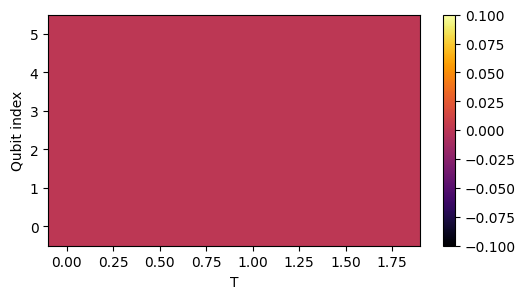

In [23]:
res_all_circuits = []
for n_steps in range(1, nb_timesteps + 1):
    res, counts = calculate_results(params_dict[n_steps])

    # create a new row to add to magnetization array
    row = [0 for _ in range(N)]
    prob = 0
    for key, value in res.items():

        prob += value
        if key[0] == "0":
            for i in range(1, N + 1):

                # if the other qubits have a result of 0, then add the probabilities to that qubit
                if key[i] == '0':
                    row[N - i] += value

    res_all_circuits += [[x/prob for x in row]]

res_all_circuits = np.array(res_all_circuits)

print(res_all_circuits.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), res_all_circuits.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

# Comparison (Fig S2)

(6, 10)


Text(0.5, 0, 'T')

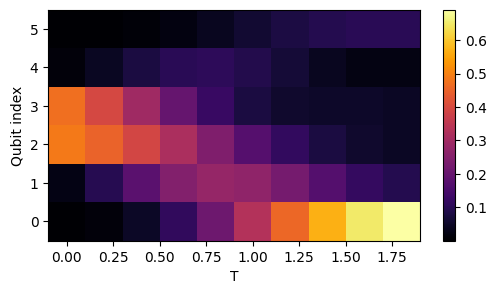

In [39]:
# For gamma = 0.2 case 
# (Full matrices and state vector based, no qiskit)
N = 6
nb_timesteps = 10
timestep_duration = 0.2
gamma = 0.2
J = 1

# Generate the unitary
matrix = get_U_HN(J, gamma , N, timestep_duration)
projection_matrix = projection(N+1)

# create the initial state vector (|↓↓↑↓↓↓⟩+|↓↓↓↑↓↓⟩)/ 2
initial_vector = np.zeros((2**(N+1), 1), dtype=complex)
initial_vector[ (2**N - 1) - 2**(N//2)] = 1/np.sqrt(2)
initial_vector[ (2**N - 1) - 2**(N//2 -1)] = 1/np.sqrt(2)

magnetization=[]
for n_steps in range(1, nb_timesteps + 1):

    # for each time step, apply the matrix n_steps times onto the initial vector
    state_vector = np.matmul(np.linalg.matrix_power(matrix @ projection_matrix, n_steps), initial_vector).T[0]
    state_dict = {}
    for i in range(2 ** (N+1)):

        # allocate the relevant probabilities to each state
        state_dict[bin(i)[2:].zfill(N+1)] = np.abs(state_vector[i]) ** 2

   
    # create a new row to add to magnetization array
    row = [0 for _ in range(N)]
    prob = 0
    for key, value in state_dict.items():

        # key[0] is the ancillary qubit
        if key[0] == '0':
            prob += value
            for i in range(1, N + 1):

                # if the other qubits have a result of 0, then add the probabilities to that qubit
                if key[i] == '0':
                    row[N - i] += value

    magnetization += [[x/prob for x in row]]

magnetization = np.array(magnetization)
print(magnetization.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

  0%|          | 0/10 [00:00<?, ?it/s]

(6, 10)


Text(0.5, 0, 'T')

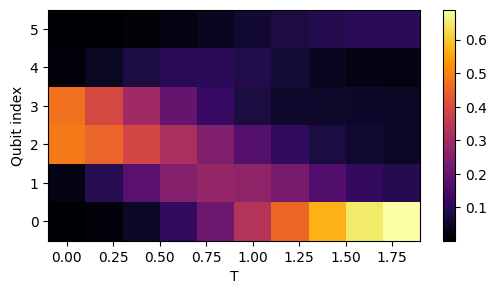

In [38]:
# For gamma = 0.2 case 
# Adapting the math representation to Qiskit
# Using Sampler
N = 6
J = 1
gamma = 0.2
timestep_duration = 0.2

# Generate the unitary
matrix = get_U_HN(J, gamma, N, timestep_duration)
projection_matrix = projection(N+1)
gate = Operator(matrix)
projector = Operator(projection_matrix)

initial_vector = np.zeros((2**(N+1), 1), dtype=complex)
initial_vector[ (2**N - 1) - 2**(N//2)] = 1/np.sqrt(2)
initial_vector[ (2**N - 1) - 2**(N//2 -1)] = 1/np.sqrt(2)


magnetization=[]
# Create the relevant circuits for paper's Fig 3a
circuits = []
for n_steps in range(1, nb_timesteps+1):
    qc = QuantumCircuit(N+1)
    state = Statevector(initial_vector)
    
    for _ in range(n_steps):
        state = state.evolve(gate)
        state = state.evolve(projector)
    
    qc.initialize(state, range(N+1), normalize=True)
    qc.measure_all()
    circuits.append(qc)

# Execute measurements for paper's Fig 3a
magnetization=[]
res_list = []
for circ in tqdm(circuits):
    pubs = [(circ)]
    job = sampler.run(pubs, shots=160000)
    results = job.result()
    res = results[0].data.meas.get_counts()

    counts_left = 0
    row = [0 for _ in range(N)]
    for key, value in res.items():
        if key[0] == "0":
            counts_left += value

            for i in range(1, N+1):
                if key[i] == '0':
                    row[i-1] += value
    magnetization.append([x/counts_left for x in row][::-1]) #the output for qiskit is qNqN-1...q1q0

magnetization=np.array(magnetization)

magnetization = np.array(magnetization)
print(magnetization.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

# nH-SSH Model

In [9]:
def get_N_total(N):
    return int(N + N/2)

In [10]:
def unitary(J, timestep):
    product_1 = np.kron(np.kron(X_gate, I_gate), X_gate)
    product_2 = np.kron(np.kron(Y_gate, I_gate), Y_gate)
    exponent = 1j * timestep * ( (J/2) * (product_1 + product_2))
    return expm(exponent)


def get_unitary(J, timestep, N):
    gate = unitary(J, timestep)
    matrix = np.kron(I_gate, I_gate)
    for _ in range(2, get_N_total(N) - 1, 3):
        matrix = np.kron(matrix, gate)
    matrix = np.kron(matrix, I_gate)
    return matrix


def get_all_U_R(J, gamma, N, timestep):
    gate = get_U_HN(J, gamma, 2, timestep)
    matrix = gate
    for _ in range(1, int(N/2)):
        matrix = np.kron(matrix, gate)
    return matrix

def get_all_projection(N):
    projection_matrix = projection(3)
    matrix = projection_matrix
    for _ in range(1, int(N/2)):
        matrix = np.kron(matrix, projection_matrix)
    return matrix


In [11]:
def check_ancillary(N, key):
    total_N = get_N_total(N)
    for i in range(total_N):
        if i % 3 == 0:
            if key[i] != "0":
                return False
    return True


In [16]:
def get_density(J, gamma, N, nb_timesteps, timestep_duration):
    total_N = get_N_total(N)

    # Generate the unitary
    matrix = get_all_U_R(J, gamma , N, timestep_duration)
    projection_matrix = get_all_projection(N)
    unitary_term = get_unitary(J, timestep_duration, N)

    # create the initial state vector (|↓↓↑↓↓↓⟩+|↓↓↓↑↓↓⟩)/ 2
    initial_vector = np.zeros((2**(total_N), 1), dtype=complex)
    binary_1 = "" #011" + "010" + "011
    binary_2 = ""
    for index in range(N):
        if index % 2 == 0:
            binary_1 += "0"
            binary_2 += "0"
        
        if index == N/2 - 1:
            binary_1 += "0"
            binary_2 += "1"
        elif index == N/2:
            binary_1 += "1"
            binary_2 += "0"
        else:
            binary_1 += "1"
            binary_2 += "1"
            
    initial_vector[int(binary_1, 2)] = 1/np.sqrt(2)
    initial_vector[int(binary_2, 2)] = 1/np.sqrt(2)

    magnetization=[]
    for n_steps in range(1, nb_timesteps + 1):

        # for each time step, apply the matrix n_steps times onto the initial vector
        state_vector = np.matmul(np.linalg.matrix_power(np.matmul(unitary_term, np.matmul(projection_matrix, matrix)), n_steps), initial_vector).T[0]
        state_dict = {}
        for i in range(2 ** (total_N)):

            # allocate the relevant probabilities to each state
            state_dict[bin(i)[2:].zfill(total_N)] = np.abs(state_vector[i]) ** 2

    
        # create a new row to add to magnetization array
        row = [0 for _ in range(N)]
        prob = 0
        for key, value in state_dict.items():

            # key[0] is the ancillary qubit
            if check_ancillary(N, key):
                prob += value
                for i in range(total_N):

                    # if the other qubits have a result of 0, then add the probabilities to that qubit
                    if i % 3 != 0:
                        if key[i] == '0':
                            real_index = i // 3 * 2 + i % 3
                            row[N - real_index] += value

        magnetization += [[x/prob for x in row]]
    return np.array(magnetization)

In [13]:

nb_timesteps = 10
timestep_duration = 0.1
gamma = 0.5
J = 2



In [17]:
density_6 = get_density(J, gamma, 6, nb_timesteps, timestep_duration)


In [18]:
density_8 = get_density(J, gamma, 8, nb_timesteps, timestep_duration)


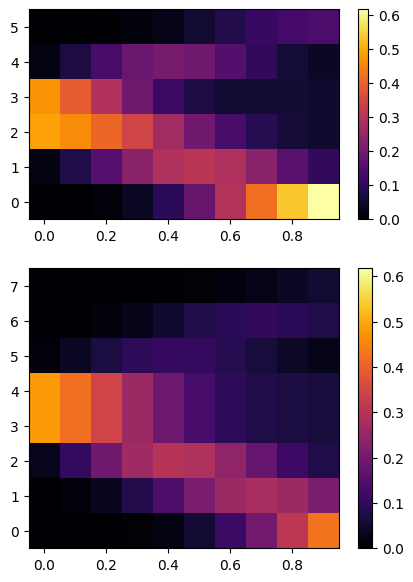

In [34]:
fig, axes = plt.subplots(2, height_ratios=[6, 8], figsize=(10/2, (6 + 8)/2))
plt.inferno()
im_0 = axes[0].pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,6,1), density_6.T, vmin=0, vmax=np.max(density_6))
im_1 = axes[1].pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,8,1), density_8.T, vmin=0, vmax=np.max(density_6))
fig.colorbar(im_0)
fig.colorbar(im_1)

Text(0.5, 0, 'T')

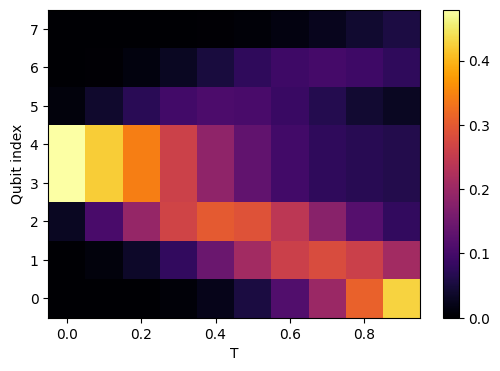

In [41]:
density_8 = magnetization
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), density_8.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')